In [1]:
import numpy as np
import cv2
import scipy.optimize as opt
import math
import matplotlib.pyplot as plt

from mpl_toolkits.mplot3d import Axes3D
#np.set_printoptions(precision=None, suppress=True)
np.set_printoptions(suppress=True)


In [85]:
rng = np.random.default_rng(2021)

In [2]:
#number of matching points
N = 8
n_images = 4
F = np.zeros((n_images,n_images,3,3))
# true_K = np.array([
#     [5,0,2],
#     [0,5,2],
#     [0,0,1]
#     ])
true_K = np.array([
    [800,0,256],
    [0,800,256],
    [0,0,1]
    ])
I = np.array([
    [1,0,0,0],
    [0,1,0,0],
    [0,0,1,0]
    ])

In [3]:
def calc_fund_matrix(points1,points2):
    '''
    Takes in 2 arrays of matching points 
    Return Fundamental matrix computes 
    using 8 point algorithm
    '''
#     F, mask = cv2.findFundamentalMat(points1,points2,cv2.FM_8POINT)
    F, mask = cv2.findFundamentalMat(points1,points2)

    return F 

In [4]:
def normalize_coordinates(p):
    # Normalization matrix
    T_m = normalization_matrix(p)
    # Normalized points
    p_norm = (T_m@(p.T)).T
    return p_norm, T_m

    
def manual_find_F_matrix(xy1,xy2):
    # Input: xy1 , xy2 - 2d array of points: row per point [x,y]
    # xy1 - for image 1, xy2 - for image 2
    # FM compute fundametal matrix from point correspondence
    #    at least 8 points are needed
    
    n_points = xy1.shape[0]
    if n_points < 8:
        print('8 points at least are needed')
    
    #add 3rd coordinate '1'
    xy1 = projectivation(xy1)
    xy2 = projectivation(xy2)
    
    
    #normalize coordinates
    xy1_norm, T1 = normalize_coordinates(xy1)
    xy2_norm, T2 = normalize_coordinates(xy2)
    
    # Preparing the equation matrix
    M = np.zeros((n_points,9))
    M[:,0] = xy1_norm[:,0]*xy2_norm[:,0] # x1 * x2
    M[:,1] = xy1_norm[:,0]*xy2_norm[:,1] # x1 * y2 
    M[:,2] = xy1_norm[:,0] # x1
    M[:,3] = xy1_norm[:,1]*xy2_norm[:,0] # y1 * x2
    M[:,4] = xy1_norm[:,1]*xy2_norm[:,1] # y1 * y2
    M[:,5] = xy1_norm[:,1] # y1
    M[:,6] = xy2_norm[:,0] # x2
    M[:,7] = xy2_norm[:,1] # y2
    M[:,8] = 1

    # calc M^T * M to get symmetruc square matrix
    W = M.T@M
    
    # desompose W into U (singular values), D (diagonal matrix), Vt (singular vectors)
    U,D,Vt = np.linalg.svd(W,compute_uv=True)
    a = U[:,-1]     # solution vector corresponding to the 
                    # least singular value
    A = np.reshape(a.T,(3,3))

    # Returning to non-normalized points
    F = np.linalg.inv(T2)@A@T1

    return F

In [5]:
### function used in class
def projectivation(p):
    '''
    Input: p, Nxd matrix = N points in R^d
    Output: q, Nx(d+1) = N points in P^d
    '''
    N,d = p.shape
    q = np.ones((N,d+1))
    q[:,0:d] = p 
    return q 

def affinization(q):
    '''
    Input: q, Nx(d+1) = N points in P^d
    Output: p, Nxd matrix = N points in R^d
    '''
    N,d1 = q.shape
    d = d1-1
    p = np.ones((N,d))
    p = q[:,0:d]/q[:,d:d+1] 
    
    return p

def normalization_matrix(p):
    '''
    Input: p: Nx2 matrix
    Output: T, normalization matrix (in projective plane) 
    '''

    # Computation
    m = np.mean(p,axis=0)
    q = p - np.repeat(m[np.newaxis,:],N,axis=0)
    w = np.sqrt(np.sum(q**2,axis=1))
    scale = 1/np.mean(w)

    # Normalization matrix
    T = np.zeros((3,3))
    T[2,2] = 1
    T[0,0] = scale
    T[0,2] = -m[0]*scale
    T[1,1] = scale
    T[1,2] = -m[1]*scale
        
    return T

In [6]:
def mendonca_cost_func(X):
    '''
    computes Mendonca & Cipolla Cost function to find the Optimal Intrinsic Parameters
    Input
    X      - Approximate Values of Intrinsics - 1D array with length 5
    Output
    E    - Computed Cost
    '''

    #Transform Intrinsics to Matrix Form
#     K = np.array([
#         [X[0],X[1],X[2]],
#         [0,X[3],X[4]],
#         [0,0,1]
#     ])
    K = np.array([
        [X[0],0,X[1]],
        [0,X[2],X[3]],
        [0,0,1]
    ])
    #Initialize Cost
    E = 0
    '''
       F - globally defined Fundamental Matrix between given two Images (F[i,j,3x3])
    '''
    # For the Denominator term of Mendonca & Cipolla's Equation
#     nof_images = len(F[0]) #number of images given
    nof_images = numberOfViews
    Den = nof_images*(nof_images-1)/2 # For N Images there are N(N-1)/2 Fundamental Matrices
  # 0 1 2 3 [0-1, 0-2,0-3, 1-2,1-3,2-3]
    # i  j
    # 0 -1 
    # 0 -2
    # 0 -3
    # 1- 2
    # 1 -3
    # 2 -3
  # len =4

    #Compute the Cost using Mendonca & Cipolla's Equation
    for i in range(0,nof_images-1):
        for j in range (i+1,nof_images):

            # Compute the Essential Matrix 'EM' from Fundamental of images i,j
#             EM = K.T @ F[i,j,:,:] @ K
            EM = K.T @ Fs[:,:,i,j] @ K

            # Compute SVD of Essential Matrix
            _,D,_ = np.linalg.svd(EM)
             # Singular Values (3rd value, D[3] is 0 according to theorem)
            r = D[0]
            s = D[1]
            
            #  Compute Cost

            E+= (1/Den) * (r - s)/s

    return E


In [7]:
def p3t(T,x,y,z):
    # apply a Projective 3D Transform
#     print(x.shape)
    xyz = np.concatenate((x, y, z),axis=1)
#     print(xyz)
#     print("np.concatenate((xyz,column_ones),axis=1)")
    column_ones = np.ones((len(x),1))
#     print(np.concatenate((xyz,column_ones),axis=1))
    tmp = T @ (np.concatenate((xyz,column_ones),axis=1)).T
    xp = (tmp[0,:]/tmp[3,:]).T
    yp = (tmp[1,:]/tmp[3,:]).T
    zp = (tmp[2,:]/tmp[3,:]).T
    return xp,yp,zp

In [36]:
def projf(P,x,y,z):
#     % PROJ  compute perspective projection (from 3D to pixel coordinates)
#     %   pixel positions are returned with floating point precision
#     %
#     %   See also PROJE
    print("P\n",P.shape)
    c3d = np.concatenate((x, y, z),axis=1)
    print("c3d\n",c3d.shape)
    column_ones = np.ones((len(x),1))
    h3d = (np.concatenate((c3d,column_ones),axis=1)).T
    print("h3d\n",h3d.shape)
    h2d = P @ h3d
    print("h2d.shape\n",h2d.shape)
#     print("h2d\n",h2d)

    c2d = h2d/ h2d[2,:]

    u = c2d[0,:].T
    v = c2d[1,:].T
    return u,v

In [37]:
def plot_3d(x,y,z):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(x,y,z)
    plt.show()

In [38]:
def plot_2d(x,y):
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.scatter(x,y)
    plt.show()

In [39]:
def conver_to_col(x):
    return np.reshape(x,(len(x),1))

In [40]:
def rcam(A):
# RCAM generate a random camera
#    generate a random camera pointing to lookp, positioned at an average 
#    distance ad form the origin, with a std dev of sd 
#    A is the intrinsic parameters matrix

    ad=2.5
    sd=0.25
    lookp=np.zeros((1,3))
    eyep = np.random.uniform(-1,1,size=(1,3))-0.5
    R = np.zeros((3,3))
    eyep = eyep/np.linalg.norm(eyep) * (ad + sd*np.random.randint(1))
#     print(eyep)
    R[2,:] = lookp - eyep/np.linalg.norm(lookp - eyep)
    R[1,:] = np.cross(R[2,:],np.random.uniform(size=(1,3)))
    R[1,:] = R[1,:]/np.linalg.norm(R[1,:])
    R[0,:] = np.cross(R[1,:],R[2,:])
    Rt = np.concatenate((R,-R @ eyep.T),axis=1)
#     print(np.matrix(Rt))
    return A @ Rt


In [41]:
numberOfViews=5
numberOfPoints = 50
imagePoints = np.zeros((numberOfPoints,2,numberOfViews))
PPM = np.zeros((3,4,numberOfViews))
PPMGT = np.zeros((3,4,numberOfViews))

In [42]:
Fs = np.zeros((3,3,numberOfViews,numberOfViews))

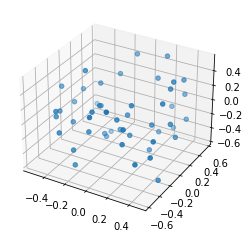

matrix P
 [[ 448.97241504  404.81828381  583.16543761  640.        ]
 [ 661.74702781 -515.85459156  -38.99886602  640.        ]
 [   0.73843337    0.48632568   -0.46712257    2.5       ]]
invAP
 [[ 0.32491684  0.35039864  0.87843602  0.        ]
 [ 0.59088511 -0.80044246  0.10073064  0.        ]
 [ 0.73843337  0.48632568 -0.46712257  2.5       ]]
lower_line
 [[0, 0, 0, 1]]
G0
 [[ 0.32491684  0.35039864  0.87843602  0.        ]
 [ 0.59088511 -0.80044246  0.10073064  0.        ]
 [ 0.73843337  0.48632568 -0.46712257  2.5       ]
 [ 0.          0.          0.          1.        ]]


In [67]:
### test same as italian
data = (np.random.uniform(size=(numberOfPoints,3),)-0.5)/(math.sqrt(3)/2)
x = data[:,0]
y = data[:,1]
z = data[:,2]
xr = np.reshape(x,(len(x),1))
yr = np.reshape(y,(len(y),1))
zr = np.reshape(z,(len(z),1))

plot_3d(x,y,z)
A = true_K
P = rcam(A)
print("matrix P\n",np.matrix(P))
invAP = np.linalg.inv(A) @ P
print("invAP\n",invAP)
lower_line = [[0,0,0,1]]
print("lower_line\n",lower_line)
G0 = np.concatenate((invAP, lower_line),axis=0)
print("G0\n",np.matrix(G0))


In [68]:
x,y,z = p3t(G0,xr,yr,zr)
P = A @ np.concatenate((np.identity(3), np.zeros((3,1))),axis=1)
# print("P\n",P)
# print(x)
# print(conver_to_col(x))
u,v = projf(P,conver_to_col(x),conver_to_col(y),conver_to_col(z))

imagePoints[:,0,0] = u
imagePoints[:,1,0] = v
PPMGT[:,:,0] = P

print("u\n",u)
print("v\n",v)

P
 (3, 4)
c3d
 (50, 3)
h3d
 (4, 50)
h2d.shape
 (3, 50)
u
 [375.7943899  344.61708482 144.03835379 141.52287227  88.60367904
 190.82744932 155.03286597 269.07981833 281.94738861 353.49267357
 170.50390895 126.58027052 389.71199537 157.0660573  128.35605324
 221.66892116 176.12023032 150.47186126 263.47980015 267.92552708
 307.87753173 469.94680291 281.61034969 346.45561936 211.50759092
 209.63514119 190.70370132  41.94942594 188.78289901 254.62252388
 393.42797532 441.13335535 414.62342448 153.92216123 433.05410429
 269.43897133 277.19215971 406.05397815 282.60159746 222.27416968
 115.58888219 268.35086261 246.84394011 301.95987889 218.7011355
 265.83956703 193.60129698 334.84186002 236.55077131 212.90179762]
v
 [352.10056055 479.73683521 377.27145494 221.82282932 355.58436538
 250.83833011  37.7917771  354.22762496 440.32188929 145.09883918
 267.17444222 205.1559178  199.63786382 291.78614089 364.93457189
 429.99419177 339.1691089  256.12670975 277.05763464 360.47990046
 169.33645528 1

P
 (3, 4)
c3d
 (50, 3)
h3d
 (4, 50)
h2d.shape
 (3, 50)


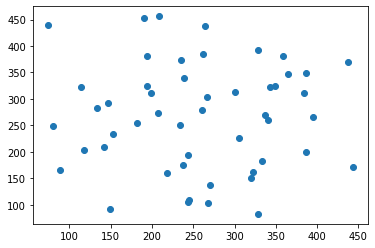

P
 (3, 4)
c3d
 (50, 3)
h3d
 (4, 50)
h2d.shape
 (3, 50)


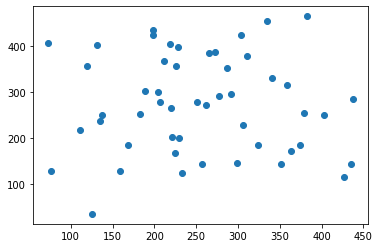

P
 (3, 4)
c3d
 (50, 3)
h3d
 (4, 50)
h2d.shape
 (3, 50)


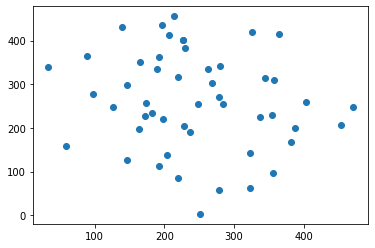

P
 (3, 4)
c3d
 (50, 3)
h3d
 (4, 50)
h2d.shape
 (3, 50)


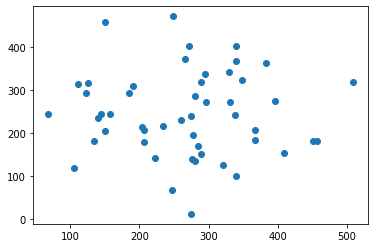

In [69]:
for view in range (1,numberOfViews):

    #   % random camera position
    P = rcam(A)

    #   % apply world coordinate transformation
    P = P @ np.linalg.inv(G0);

    #   % project world points to image points
    u,v = projf(P,conver_to_col(x),conver_to_col(y),conver_to_col(z))

    #   % add noise to image points
    #       u = u + sigma * randn(size(u));
    #       v = v + sigma * randn(size(v));

    imagePoints[:,0,view] = u
    imagePoints[:,1,view] = v

    PPMGT[:,:,view] = P   
    plot_2d(u,v)

In [70]:

for i in range(numberOfViews):
    for j in range(i+1,numberOfViews):
        Fs[:,:,i,j] = calc_fund_matrix(imagePoints[:,:,i],imagePoints[:,:,j])

In [71]:
initial_K =  [true_K[0,0], true_K[0,2],true_K[1,1],true_K[1,2]]
res = opt.minimize(mendonca_cost_func,x0=initial_K, method='Nelder-Mead')

In [72]:
result_K = np.zeros((3,3))
result_K = np.array([[res.x[0],0,res.x[1]],[0,res.x[2],res.x[3]],[0,0,1]])
print (np.matrix(result_K))

[[800.05504475   0.         255.99961934]
 [  0.         800.05500608 256.00067955]
 [  0.           0.           1.        ]]


In [73]:
print(data)

[[ 0.40286953 -0.05567244  0.31997473]
 [ 0.15299238 -0.57487142  0.44098811]
 [ 0.478761   -0.27715629 -0.53985633]
 [-0.15511891 -0.02276945 -0.34670894]
 [-0.18778015 -0.51734962 -0.25510819]
 [-0.00941536 -0.01511634 -0.23101765]
 [-0.48668086  0.45837097 -0.36703853]
 [ 0.0948617  -0.27952396  0.12066696]
 [ 0.25178479 -0.47331885  0.18318443]
 [-0.17763647  0.31810686  0.27132276]
 [ 0.23190056  0.06168095 -0.46546334]
 [-0.16587588  0.02950438 -0.42769807]
 [ 0.15065724  0.38263155  0.2974579 ]
 [-0.41047198 -0.40916963  0.03614869]
 [-0.29394256 -0.56540923 -0.03328257]
 [ 0.46645959 -0.41009167 -0.14139566]
 [-0.11286678 -0.38440799 -0.06163467]
 [-0.33225834 -0.25838881 -0.10080558]
 [ 0.06850278 -0.03085142  0.01388716]
 [-0.08136675 -0.38338274  0.21952404]
 [-0.27283715  0.13182888  0.21531936]
 [ 0.17435986  0.5121007   0.53174174]
 [-0.00147399 -0.57305645  0.30485328]
 [ 0.33166336  0.54769475  0.04382082]
 [ 0.20283681  0.30484156 -0.38516351]
 [ 0.13789535 -0.12638638

In [75]:
print(PPMGT)

[[[  800.           811.48569525   829.49889682   789.96414086
      20.72103215]
  [    0.           -68.49617017   132.1613771   -280.26202106
     383.69116461]
  [  256.          -205.75529415    -0.97497702   -54.27573771
     746.91882359]
  [    0.          1154.38823536   642.43744254   775.68934428
   -1227.29705897]]

 [[    0.           283.40452655   -54.40816415   188.39266756
    -399.69166626]
  [  800.           452.09633995   837.60003071   431.84497203
    -612.29904076]
  [  256.           648.71162602    31.65343958  -695.38055979
     413.36721763]
  [    0.          -981.77906506   560.86640105  2378.45139949
    -393.41804408]]

 [[    0.             0.42652158     0.26381872     0.60796762
       0.67299363]
  [    0.            -0.63097939     0.2879828      0.74948356
      -0.47417912]
  [    1.             0.64803113     0.92057894     0.26201099
       0.56765635]
  [    0.             0.87992218     0.19855265     1.84497252
       1.08085912]]]


In [77]:
print(G0)

[[ 0.32491684  0.35039864  0.87843602  0.        ]
 [ 0.59088511 -0.80044246  0.10073064  0.        ]
 [ 0.73843337  0.48632568 -0.46712257  2.5       ]
 [ 0.          0.          0.          1.        ]]


In [78]:
state = np.random.get_state()
print(state)

('MT19937', array([3122787423, 3721310838, 1204026599, 1952118866, 3323835918,
       4060200507,  552735203,  476751965,  724620709, 3538565514,
       1331808216, 4026268235, 2528324086, 1846367101, 2989679635,
       3389372164, 2332755575, 1991695778, 1513731169, 1528912078,
        596762433, 2166011432, 4101919988,  457493721, 1084843444,
       3836023702, 3348519974, 3209935254,  777996722, 2442515456,
        493719164,  313272819, 1060049429,  656710158, 1179257121,
       1138378906,   49926297, 1174818907, 2787030037, 1237207833,
       3779185784, 2823451280, 4201715515, 1942681989, 1099978037,
       1485354926, 2408716778, 1088310067,  863035540, 3185622018,
       2613525622, 2513699115,  211861821, 2602735364, 1130170447,
       3402297933, 3476250001,  630364569, 1023164387, 4126853388,
       2341940936, 4245413334, 1779954305, 3599302030, 2619532385,
       1171212580, 2793649452, 4199560457, 2430205153,  194082778,
       2214269016, 1158629392,  567778160, 3215900

In [79]:
import pandas as pd

In [82]:
points = pd.DataFrame(data)
points.to_csv('points.csv', index=False)  

In [ ]:
eyep = np.random.uniform(size=(1,3))-0.5
print(eyep)

In [ ]:
def randomize_rt():
    angle = np.random.uniform(0,45)
    cos =  math.cos(angle)
    sin =  math.sin(angle)
#     t = np.random.randint(-5,5,(3,1))
    t = np.zeros((3,1))
    t[2] = 1
    t = np.zeros((3,1))
    R = np.array([[cos,-sin,0],[sin,cos,0],[0,0,1]])
    Rt = np.concatenate((R,t),axis=1)
    print(Rt)
    low_row = np.zeros((1,4))
    low_row[:,-1] = 1
    Rt = np.concatenate((Rt,low_row),axis=0)
#     lowes_row = np.array([0,0,0,1])
#     Rt = np.concatenate((Rt,lowes_row),axis=0)
    print (np.matrix(Rt))
    return Rt

In [ ]:
rt = randomize_rt()


In [ ]:
def randomize_3d_points(num_of_points):
    world_points = np.random.uniform(-1,1,(num_of_points,3))
    return world_points

def get_projection_of_points(world_points):
    world_points_hom = projectivation(world_points)
    return world_points_hom

In [ ]:
world_points = randomize_3d_points(N)
T1 = normalization_matrix(world_points)
world_points_hom = get_projection_of_points(world_points)

In [ ]:
world_points_hom.shape

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(world_points[:,0],world_points[:,1],world_points[:,2])
plt.show()

In [ ]:
(world_points_hom[0])

In [ ]:
image0_p0 = np.zeros(3)
rt = randomize_rt()
k_extended = np.concatenate((true_K,np.zeros(shape=(3,1))),axis=1)
print(k_extended)
image0_p0 = k_extended @ world_points_hom[0]

In [ ]:
image0 = np.zeros((N,3))
for i in range(N):
    image0[i,:] = true_K @ I @ world_points_hom[i]
    image0[i,:] = image0[i,:]/image0[i,-1]

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.scatter(image0[:,0],image0[:,1])
plt.show()

In [ ]:
projected = np.zeros((n_images,N,3))

for image in range(n_images):
    if (image == 0): # use the first image as it was not rotated
#         rt = I
        rt = np.identity(4)
    else:
        rt = randomize_rt()
    print (np.matrix(rt))
    for point in range(N):
#         projected[image,point,:] = true_K @ rt @ world_points_hom[point]
        projected[image,point,:] = k_extended @ rt @ world_points_hom[point]
        projected[image,point,:]/= world_points[point,-1]


In [ ]:
print(projected)

In [ ]:
fig, axes = plt.subplots(2, 2, figsize=(10,20))

for i, ax in enumerate(axes.ravel()):
    ax.scatter(projected[i,:,0],projected[i,:,1], alpha=.5)
    ax.grid()
    
plt.tight_layout()

In [ ]:
for i in range(n_images-1):
    for j in range(i+1,n_images):
        F[i,j] = calc_fund_matrix(projected[i,:,0:2],projected[j,:,0:2])

In [ ]:
np.matrix(F[0,1])

In [ ]:
for i in range(n_images-1):
    for j in range(i+1,n_images):
        print(i,j)
        print(np.matrix(F[i,j]))

In [ ]:
initial_K =  np.random.randint(-5,5,(5))
res = opt.minimize(mendonca_cost_func,x0=initial_K, method='Nelder-Mead')
# res = opt.minimize(mendonca_cost_func,x0=initial_K)

In [ ]:
res

In [ ]:
result_K = np.zeros((3,3))
result_K = np.array([[res.x[0],res.x[1],res.x[2]],[0,res.x[3],res.x[4]],[0,0,1]])
print (np.matrix(result_K))

In [ ]:
print(np.matrix(true_K))

In [ ]:
image0_p0/image0_p0[2]

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(world_points[:,0],world_points[:,1],world_points[:,2])
plt.show()

In [ ]:
# EXPERIMENT

# array of n_images with original coordinates of N points (x,y)
p = np.zeros((n_images,N,2))
# array of n_images with projective coordinats of M points (x,y,1)
pj = np.zeros((n_images,N,3))

# randomly initialize 1st image (index #0)
p[0] = np.random.randint(0,500,(N,2))
pj[0] = projectivation(p[0])

#init random matrices to transform original image
A = np.random.randint(-6,6,(n_images-1,3,3))
A[:,] = np.triu(A[:,])
# transform original image to get new images 
for i in range(1,n_images):
    pj[i] = (A[i-1]@pj[0].T).T
    p[i] = affinization(pj[i])
   
# insert noise
noise_level1 = 0.25
for i in range(n_images):
    p[i] += noise_level1*np.random.randn(N,2)

In [ ]:
print (A[0])

In [ ]:
print (p.shape)

In [ ]:
for i in range(n_images-1):
    for j in range(i+1,n_images):
        F[i,j] = calc_fund_matrix(p[i],p[j])

In [ ]:
initial_K =  np.random.randint(-5,5,(5))

In [ ]:
res = opt.minimize(mendonca_cost_func,x0=initial_K, method='Nelder-Mead')

In [ ]:
print (res)

In [ ]:
result_K = np.zeros((3,3))
result_K = np.array([[res.x[0],res.x[1],res.x[2]],[0,res.x[3],res.x[4]],[0,0,1]])
print (np.matrix(result_K))

In [ ]:
#reconststruction

#find Fundamental matrix
F12 = np.zeros((3,3))
F12 = calc_fund_matrix(p[0],p[1])

#find Essential matrix
EM = result_K.T @ F @ result_K

#factorize EM to find R,t
U,D,Vt = np.linalg.svd(EM)

In [ ]:
randomize_rt()